In [1]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
from openrarity import TokenCollection
from collections import defaultdict
import numpy as np
import math
from tqdm import tqdm

DATA = Path("../data/regression-tests/")
_100a1 = {p.stem: p for p in (DATA / "1.0.0a1").glob("*.json")}
_071b0 = {p.stem: p for p in (DATA / "0.7.1b0").glob("*.json")}
collections = set(_100a1).intersection(set(_071b0))


# Rank Collections


In [64]:
collections = list((DATA / "metadata").glob("*.json"))

for c in (pbar := tqdm(collections)):
    pbar.set_description(c.stem)

    tokens = json.loads(c.read_text())
    tc = TokenCollection("non-fungible", tokens)
    ranks = tc.rank_collection()
    (DATA / f"1.0.0a1/{c.stem}.json").write_text(json.dumps(ranks, indent=2))
    del tokens, tc, ranks


bored-ape-chemistry-club: 100%|██████████| 93/93 [03:26<00:00,  2.22s/it]      


# Compare Versions


Match: 40	MisMatch: 26


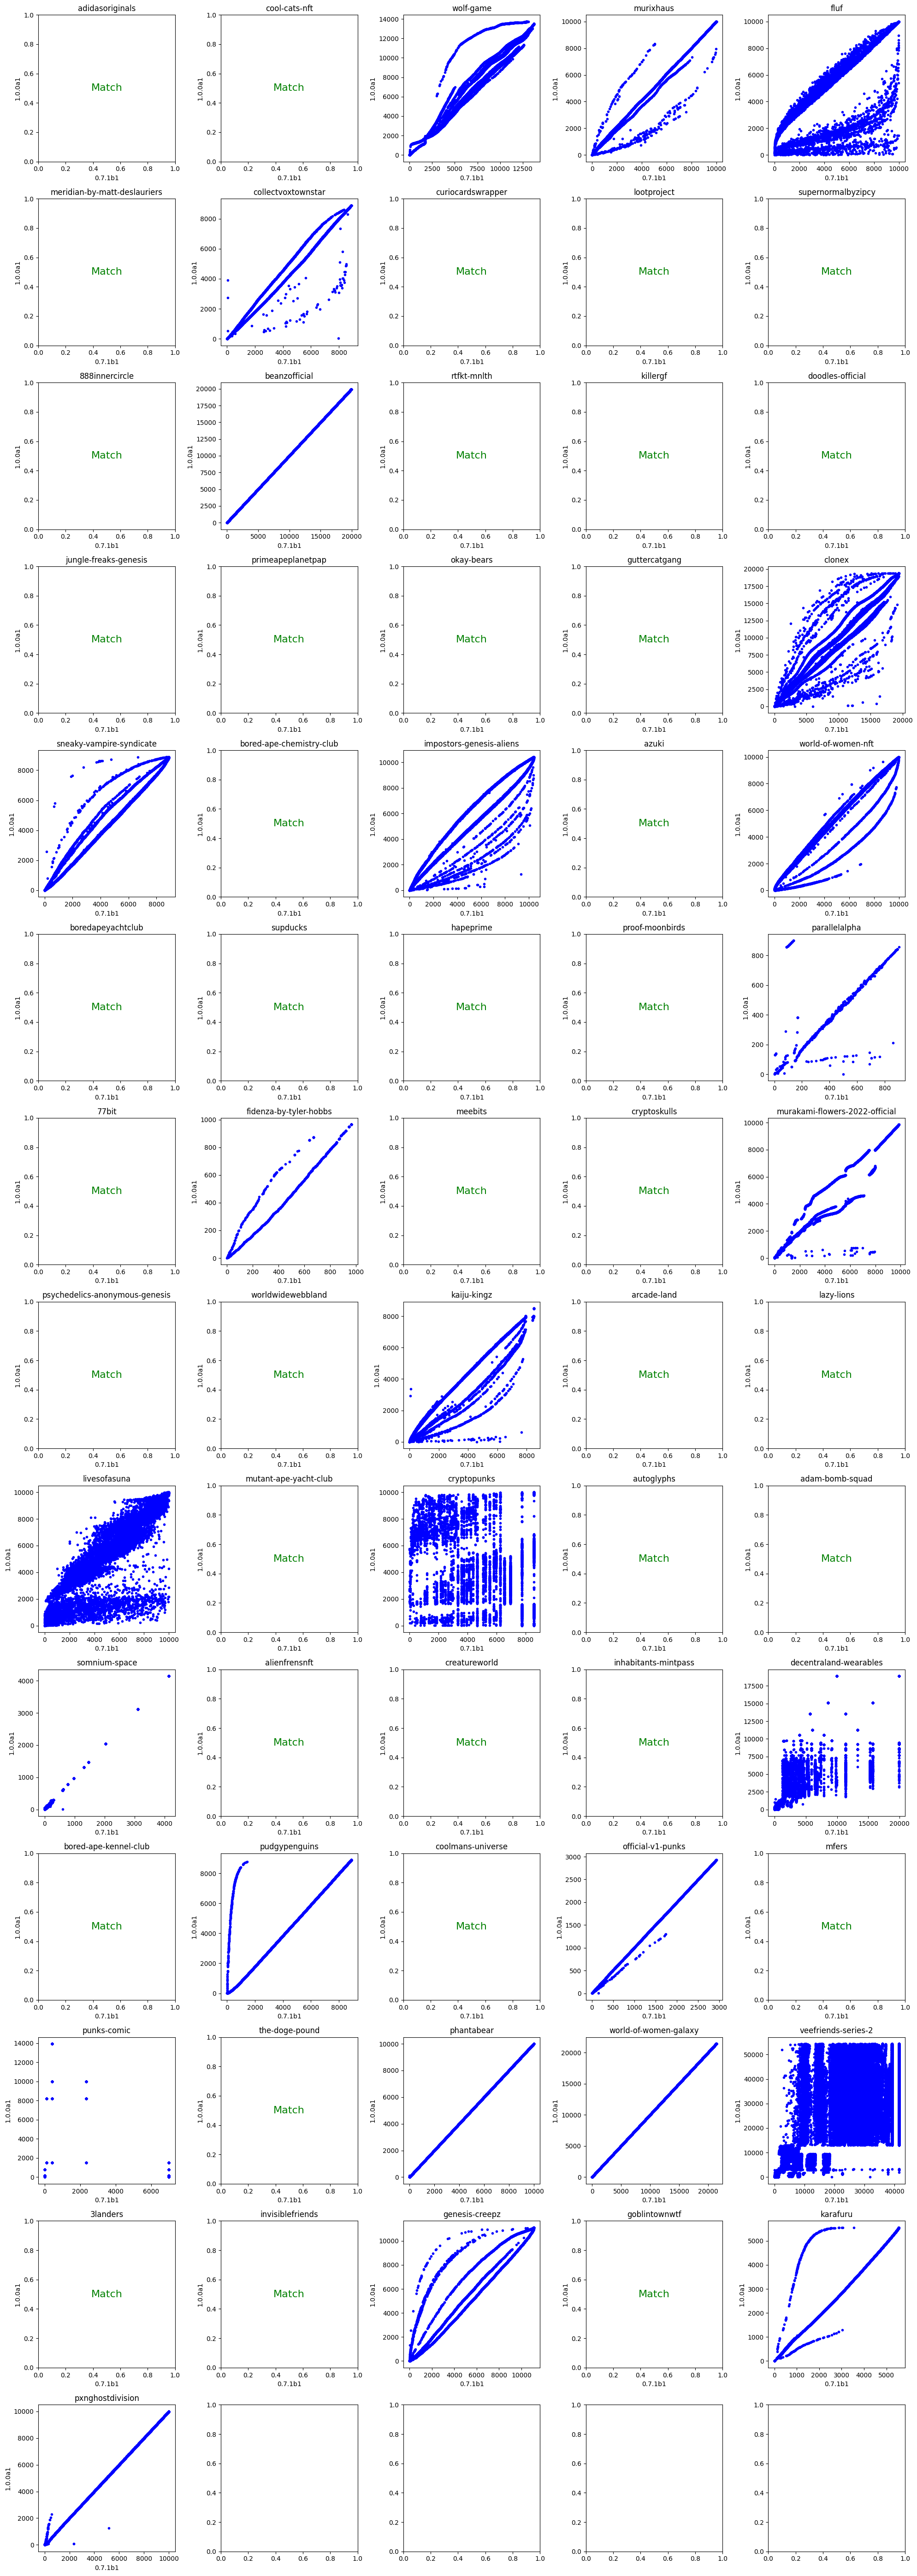

In [8]:
plt.close("all")
ncols = 5
nrows = math.ceil(len(collections) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = axes.flatten()

comps = {}
matches = defaultdict(list)
for i, c in enumerate(collections):
    old = json.loads(_071b0[c].read_text())
    joined = pd.DataFrame(
        [
            {"token_id": t["token_id"], "old": old[t["token_id"]], "new": t["rank"]}
            for t in json.loads(_100a1[c].read_text())
        ]
    )
    _matches = bool(np.prod(joined["old"] == joined["new"]))
    matches[_matches].append(c)
    comps[c] = joined
    axes[i].set_title(c)
    axes[i].set_xlabel("0.7.1b1", fontsize=10)
    axes[i].set_ylabel("1.0.0a1", fontsize=10)
    if not _matches:
        axes[i].plot(joined["old"], joined["new"], "b.")
    if _matches:
        axes[i].annotate(
            "Match",
            xy=(0.5, 0.5),
            xytext=(0.5, 0.5),
            xycoords="axes fraction",
            color="green",
            fontsize=16,
            ha="center",
            va="center",
        )
print(f"Match: {len(matches[True])}\tMisMatch: {len(matches[False])}")
fig.tight_layout()

plt.show()


In [14]:
COLLECTION = "sneaky-vampire-syndicate"
data = json.loads((DATA / f"metadata/{COLLECTION}.json").read_text())

tc = TokenCollection("non-fungible", data)

ranks = tc.rank_collection()
ranks


[{'token_id': '3044',
  'metric.probability': 6.606319930700458e-29,
  'metric.max_trait_information': 13.117643101389092,
  'metric.information': 93.612067913618,
  'metric.unique_trait_count': 1,
  'metric.information_entropy': 0.08045093472291522,
  'rank': 1},
 {'token_id': '604',
  'metric.probability': 6.606319930700458e-29,
  'metric.max_trait_information': 13.117643101389092,
  'metric.information': 93.612067913618,
  'metric.unique_trait_count': 1,
  'metric.information_entropy': 0.08045093472291522,
  'rank': 1},
 {'token_id': '7086',
  'metric.probability': 6.606319930700458e-29,
  'metric.max_trait_information': 13.117643101389092,
  'metric.information': 93.612067913618,
  'metric.unique_trait_count': 1,
  'metric.information_entropy': 0.08045093472291522,
  'rank': 1},
 {'token_id': '5304',
  'metric.probability': 6.606319930700458e-29,
  'metric.max_trait_information': 13.117643101389092,
  'metric.information': 93.612067913618,
  'metric.unique_trait_count': 1,
  'metri

In [13]:
tc.attribute_statistics


{'string': [{'name': 'hair',
   'value': 'green',
   'attribute.token_count': 599,
   'attribute.supply': 599,
   'metric.probability': 0.06739423942394239,
   'metric.information': 3.8912309086003063},
  {'name': 'glasses',
   'value': 'glasses',
   'attribute.token_count': 906,
   'attribute.supply': 906,
   'metric.probability': 0.10193519351935193,
   'metric.information': 3.294275861342857},
  {'name': 'eyes',
   'value': 'gold eyes',
   'attribute.token_count': 253,
   'attribute.supply': 253,
   'metric.probability': 0.028465346534653466,
   'metric.information': 5.134649526694782},
  {'name': 'moon',
   'value': 'sun',
   'attribute.token_count': 2497,
   'attribute.supply': 2497,
   'metric.probability': 0.28094059405940597,
   'metric.information': 1.8316629954608796},
  {'name': 'mouth',
   'value': 'base',
   'attribute.token_count': 3072,
   'attribute.supply': 3072,
   'metric.probability': 0.34563456345634563,
   'metric.information': 1.5326806006679359},
  {'name': 'bac